# Exploring Seismograms

This is a script to compare data to synthetics. 
At the top there are a number of parameteres to change:
- What to plot (data/synthetics)
- What frequencies to plot
- What componeent to plot
- What phase to center on
- Which travel times to plot
- Organizing seismograms as a function of distance or azimuth

Code blocks can be run with shift-enter.
NOTE: every time you change something, you need to re-run  that code-block, before rerunnign the last code block (which does the actual plotting)

In [1]:
%matplotlib inline
import obspy
import obspy.taup
from obspy import read
from obspy import UTCDateTime
import obspy.signal
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import geographiclib
import numpy as np
import sys
sys.path.insert(1, './basemap')
from mpl_toolkits.basemap import Basemap
import glob

plt.rcParams["figure.figsize"] = (14,10)

## Event Name and Data Loading
There is only one event available to you. <br>
Loading data, this takes a while, but this code block only needs to be run once.

In [2]:
event = '20161225'
datalist = read(event +'data.PICKLE')
instaseislist = read(event+'instaseis.PICKLE')
shakemovielist = read(event+'shakemovie.PICKLE')

print('done loading')

done loading


## DEFINE SUBPLOTS
This sets the number of subplots. <br>
Choose from 'realdata', 'instaseis', 'shakemovie

In [3]:
subplots = ['realdata', 'instaseis']

## SETTING FREQUENCY LIMITS
or 1/periods <br>
Note, the fmax will be reset if using specific synthetics, which are
only valid up to specific frequencies <br>

In [4]:
fmin = 1. / 30.
fmax = 1. / 10.

## COMPONTENT TO PLOT
Choose 'Z' for vertical, 'T' for transverse, or 'R' for radial <br>
All three could be plotted with e.g. compontents = ['T','R','Z']

In [5]:
components = ['T']
compcolors = ['k', 'r', 'b'] # Colors used to plot components

## PHASE TO CENTER ON
if first phase doesn't exist at a specific distance, secondary phase will be tried
(only one backup phase can be given)

In [6]:
center_phase = ['Sdiff', 'S']

## TRAVEL TIMES TO PLOT
phases follow taup naming conventions, see:  <br>
https://docs.obspy.org/packages/obspy.taup.html <br>
A number of phases are precomputed and stored with the data, others will slow down the script to compute on the fly

In [7]:
tt_phases = ['Sdiff', 'S']

## Y-AXIS
Chooose to plot with distance or azimuth <br>
Choose 'dist' or 'az' <br>
'round' sets if seismograms are plotted at values rounded to whole numbers (this generally makes the plot easier to look at). 

In [8]:
yaxis = 'dist'
round = True

## LIMITS OF THE PLOT
-azimuth limits (data is included between 300 and 360 deg) <br>
-distance limits (data is included between 90 and 130 deg) <br>
-Time limits (Window around center phase)

In [9]:
azmin = 300.
azmax = 360.

distmin = 90
distmax = 135

timemin = -130
timemax = 150

## NORMALIZATION FACTOR
factor to normalize all data by to improve plot <br>

In [10]:
fact = 10.

## PLOTTING DATA
All the plotting happens after this, and in principle doesn't
need to be changed... although you are welcome to play
around/ improve/ break it...

plotting  realdata ...
plotting  instaseis ...


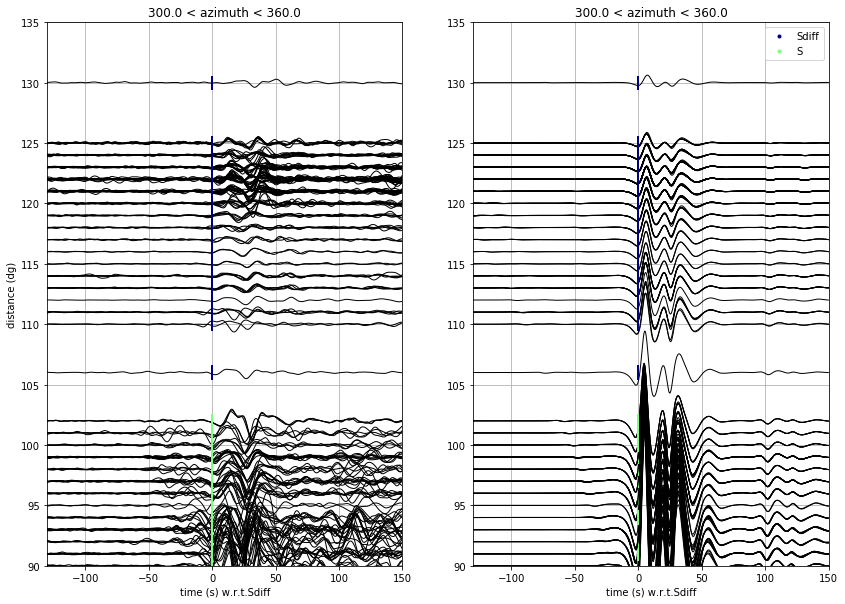

In [73]:
# Colormap for travel times
cNorm = colors.Normalize(vmin=0, vmax=len(tt_phases))
tt_cmap = cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('jet'))

# Setting the maximum feasible frequencies when synthetics are included
if 'shakemovie' in subplots and fmax>1./17.:
    print('Warning: max frequency set to 1/17 Hz as anything higher is not valid for shakemovie synthetics')
    fmax = 1./17. # Shakemovie synthetics are only valid for periods down to 17 seconds
if 'instaseis' in subplots and fmax>1./2.:
    print('Warning: max frequency set to 1/2 Hz as anything higher is not valid for instaseis synthetics')
    fmax = 1./2. # Instaseis synthetics included are only valid for periods down to 2 seconds
if fmax > 1.:
    print('Warning: max frequency set to 1 Hz as anything higher is pre-filtered from the data')
    fmax = 1.

prem = obspy.taup.TauPyModel('prem')


slon = []
slat = []
elon = []
dists =[]

# Loop through data types
for plotnum, sub in enumerate(subplots):
    plt.subplot(1, len(subplots), 1+plotnum)
    print('plotting ', sub, '...')
    if sub == 'realdata':

        allseis = datalist.copy()
        norm = 1.e-4
    elif sub == 'instaseis':
        allseis = instaseislist.copy()
        norm = 1.e-4
    elif sub == 'shakemovie':
        allseis = shakemovielist.copy()
        norm = 1.e-4
    else:
        print(sub, 'option is unknown, choose realdata, instaseis, or shakemovie')

    # Loop through components
    for c, comp in enumerate(components):
        seislist = allseis.select(channel='*' + comp)
        # Loop through seismic receivers
        for s,seis in enumerate(seislist):

            if seis.stats['az'] > azmin and seis.stats['az'] < azmax:
                if seis.stats['dist'] > distmin and seis.stats['dist'] < distmax:

                    center_time = seis.stats.traveltimes[center_phase[0]]
                    if len(center_phase) > 1:
                        if center_time is None:
                            center_time = seis.stats.traveltimes[center_phase[1]]
                    if center_time is None:
                        continue

                    seis.filter('highpass',freq=fmin,corners=2,zerophase=True)
                    seis.filter('lowpass',freq=fmax,corners=2,zerophase=True)

                    xplot = seis.times(
                        reftime=UTCDateTime(
                            seis.stats['eventtime'])) - center_time
                    win1 = np.argmin(np.abs(xplot - timemin))
                    win2 = np.argmin(np.abs(xplot - timemax))
                                                    
                    if round:
                        yloc = np.round(seis.stats[yaxis])
                    else:
                        yloc = seis.stats[yaxis]
                    yplot = fact * seis.data / norm + yloc
                    plt.plot(xplot[win1:win2], yplot[win1:win2], compcolors[c], linewidth=1)

                    

                    # Plot travel times
                    if c==(len(components)-1) and plotnum == len(subplots)-1:
                        for ph, phase in enumerate(tt_phases):
                            if phase in seis.stats.traveltimes:
                              if seis.stats.traveltimes[phase] is not None:
                                xtime = seis.stats.traveltimes[phase] - center_time

                                for i in range(len(subplots)):
                                    plt.subplot(1, len(subplots), 1+i)
                                    plt.plot([xtime, xtime], [yloc - 0.5,yloc + 0.5],
                                         color=tt_cmap.to_rgba(ph), linewidth=2)
                            else:
                                arrs = prem.get_travel_times(seis.stats['evdp'],seis.stats['dist'], phase_list = (phase,))
                                if len(arrs)>0:
                                    for arr in arrs:
                                        xtime = arr.time - center_time
                                        for i in range(len(subplots)):
                                            plt.subplot(1, len(subplots), 1+i)
                                            plt.plot([xtime, xtime], [yloc - 0.5,yloc + 0.5],
                                                 color=tt_cmap.to_rgba(ph), linewidth=2)
                                            
                        #Save locations to plot
                        if elon == []:
                            elon = seis.stats['evlo']
                            elat = seis.stats['evla']
                            edep = seis.stats['evdp']
                        slon.append(seis.stats['stlo'])
                        slat.append(seis.stats['stla'])
                        dists.append(seis.stats['dist'])

# plot some fake points to make an okay legend
for ph, phase in enumerate(tt_phases):
    plt.plot(0, 0, '.', color=tt_cmap.to_rgba(ph), label=phase)
plt.legend()

# prettify plots
for i in range(len(subplots)):
    plt.subplot(1, len(subplots), i + 1)
    plt.xlabel('time (s) w.r.t.' + center_phase[0])
    if yaxis == 'dist':
        if i ==0:
            plt.ylabel('distance (dg)')
        plt.ylim([distmin, distmax])
        plt.title(str(azmin) + ' < azimuth < ' + str(azmax))
    if yaxis == 'az':
        if i ==0:
            plt.ylabel('azimuth (dg)')
        plt.ylim([azmin, azmax])
        plt.title(str(distmin) + ' < distance < ' + str(distmax))
    plt.xlim([timemin, timemax])
    plt.grid()
plt.show()

# Background model
Model provided to plot on the map is S362ANI+M (Moulik & Ekstrom, 2014). This model is an update of the model S362ANI (Kustowski et al. 2008) which is used as the background model for the 3D shakemovie synthetics. <br>
Choose which depth to plot. This can be 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 500, 600, 700, 800, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 2800, or 2890 km. <br>
Choose what to plot 'vsv', 'vsh', or 'voigt'. <br>
Choose 'absolute' or 'relative'. 

In [61]:
model = 'S362ANI+M' # No other model currently provided
depth_mod = 2800
to_plot = 'voigt'
abs_or_rel = 'absolute'

# Load model
mod = np.loadtxt(model+'/'+model+'.'+to_plot+'.'+str(int(depth_mod))+'.txt', 
           dtype={'names': ('lon', 'lat', 'vel'),'formats': ('f4', 'f4', 'f4')})  

# Reshape for plotting
len1= len(np.unique(mod['lon']))
len2= len(np.unique(mod['lat']))
lon = mod['lon'].reshape((len2,len1))
lat = mod['lat'].reshape((len2,len1))
vel = mod['vel'].reshape((len2,len1))
print('model loaded')

model loaded


# Compute pierce points
For given phase(s) and a depth


In [74]:
pp_depth = depth_mod # Depth to compute pierce point at
pp_phases = center_phase # Phase(s) for piercepoints, can be set to center_phase


downgoing =[]
upgoing=[]
for d in range(len(dists)):
        # Compute ray paths
        arrs = prem.get_ray_paths_geo(source_depth_in_km=edep, 
                                          source_latitude_in_deg=elat,
                                          source_longitude_in_deg=elon,
                                          receiver_latitude_in_deg=slat[d],
                                          receiver_longitude_in_deg=slon[d],
                                          phase_list=pp_phases)
        for A in arrs:
            p=A.path
            cut = np.argmax(p['depth'])
            # Only select rays that go deep enough
            if pp_depth < np.max(p['depth']):
                # Interpolate downgoing pierce point
                downgoing.append((np.interp(pp_depth, p['depth'][:cut],p['lon'][:cut] ), 
                             np.interp(pp_depth, p['depth'][:cut],p['lat'][:cut])))

                # Interpolate upgoing pierce point           
                upgoing.append((np.interp(pp_depth, p['depth'][cut:][::-1],p['lon'][cut:][::-1] ), 
                             np.interp(pp_depth, p['depth'][cut:][::-1],p['lat'][cut:][::-1])))

downgoing=np.asarray(downgoing)
upgoing=np.asarray(upgoing)
print('done computing pierce points')

done computing pierce points


## Plotting Map
Uses the selection of data from above

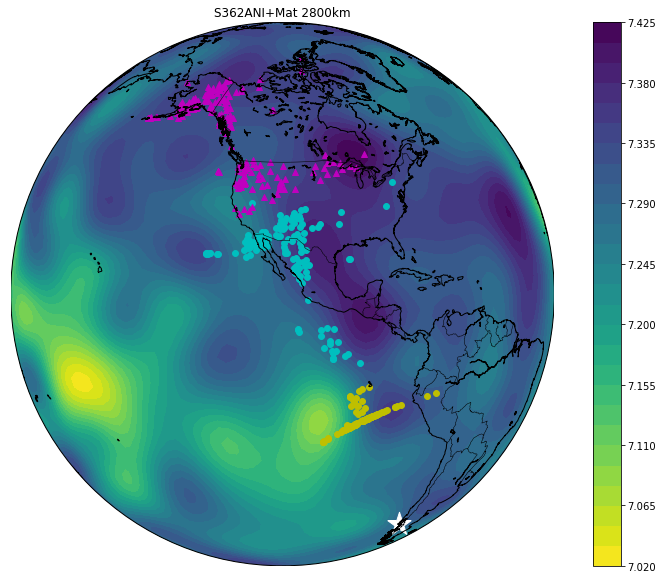

In [75]:
plot_tomography = True # Choose to plot background seismic model
plot_piercepoints = True # Choose to plot pierce points computed above

# Plot map background
m = Basemap(projection='ortho',lat_0=20.,lon_0=-110,resolution='l')
m.drawcoastlines()
m.drawcountries()

# Plot tomographic model
if plot_tomography:
    x,y = m(lon,lat)
    if abs_or_rel == 'relative':
        ref = np.mean(vel.ravel())
        rel = (vel-ref)/ref*100.
        lim = np.ceil(np.max(np.abs(rel)))
        levels = np.linspace(-lim,lim,33)
        m.contourf(x,y,rel,levels=levels,cmap=cm.seismic_r,linewidth=0)
    if abs_or_rel == 'absolute':
        m.contourf(x,y,vel,33, cmap=cm.viridis_r,linewidth=0)    

    plt.colorbar()
    plt.title(model + 'at ' +str(int(depth_mod)) + 'km')

#Plot pierce points
if plot_piercepoints:
    x2,y2=m(downgoing[:,0], downgoing[:,1])
    m.scatter(x2,y2,s=35,c='y',marker='o',alpha=1)
    x2,y2=m(upgoing[:,0], upgoing[:,1])
    m.scatter(x2,y2,s=35,c='c',marker='o',alpha=1)

#Plot event
x2,y2=m(elon+360.,elat)
m.scatter(x2,y2,s=600,marker='*',facecolors='w',alpha=1)
#Plot stations
slon=[slon[x]+360. if slon[x]<0 else slon[x]  for x in range(len(slon))]
x2,y2=m(slon,slat)
m.scatter(x2,y2,s=35,c='m',marker='^',alpha=1)
